### Объединение классификаторов с помощью мажоритарного голосования
Построим более сильный метаклассификатор, который компенсирует слабость отдельных классификаторов на конкретном наборе данных. 

In [30]:
import pandas as pd
import numpy as np
import warnings
import six
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
from itertools import product
import operator
warnings.filterwarnings('ignore')

In [21]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel1', weights=None):
        #classifiers - различные классификаторы
        #vote - определяет тип голосования,
        # если "classlabel1" - используем argmax
        # если "probability" - используем голосование, основанное на вероятностях
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X): # прогнозируем метки классов
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x,weights=self.weights)), axis=1,arr=predictions)
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self, X): # используем для вероятностей 
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        # avg_proba - взвешенная усредненная вероятность для каждого класса на образец
        return avg_proba 
    
    def get_params(self, deep=True):
        #получаем параметры для решетчатого поиска
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name,key)] = value
                    
            return out

Протестируем наш класс. Используем датасет - ирисы, но возьмем только два признака

In [22]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=1, stratify=y)

In [24]:
# Определим наши классификаторы
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

In [25]:
# Объединим их в pipeline
pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],['clf', clf3]])
clf_labels = ['Логистическая регрессия', 'Дерево принятия решений', 'KNN']
print('Перекрестная проверка по 10 блокам:\n')
for clf, label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train, y=y_train,cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s] " % (scores.mean(), scores.std(), label))

Перекрестная проверка по 10 блокам:

ROC AUC: 0.92 (+/- 0.15) [Логистическая регрессия] 
ROC AUC: 0.87 (+/- 0.18) [Дерево принятия решений] 
ROC AUC: 0.85 (+/- 0.13) [KNN] 


Теперь объединим наши классификаторы

In [26]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Мажоритарное голосование']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                            X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("Правильность: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Правильность: 0.92 (+/- 0.15) [Логистическая регрессия]
Правильность: 0.87 (+/- 0.18) [Дерево принятия решений]
Правильность: 0.85 (+/- 0.13) [KNN]
Правильность: 0.98 (+/- 0.05) [Мажоритарное голосование]


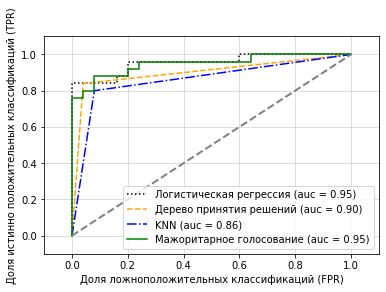

In [27]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, tresholds = roc_curve(y_true = y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color = clr, linestyle=ls, label ='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Доля ложноположительных классификаций (FPR)')
plt.ylabel('Доля истинно положительных классификаций (TPR)')
plt.show()

По графику можно заметить, что ансамблевый классификатор хорошо работает на испытательном наборе. Однако можно заметить, что классификатор, в основе которого лежит логистическая регрессия работает в равной степени хорошо. 
Построим график, который будет показывать область решений ансамблевого классификатора и каждого из них по отдельности. 

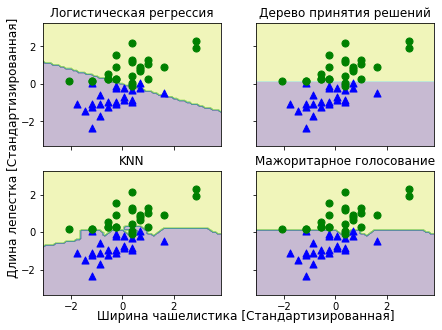

In [28]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
x_min = X_train_std[:,0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:,1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
# np.meshgrid - возвращает координатные матрицы из координатных векторов
f,axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))

for idx, clf, tt in zip(product([0,1], [0,1]),all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx,yy,Z,alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0,0], X_train_std[y_train ==0, 1], 
                                 c = 'blue', 
                                 marker='^',
                                 s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1,0], X_train_std[y_train ==1, 1], 
                                 c = 'green', 
                                 marker='o',
                                 s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -4.5, s='Ширина чашелистика [Стандартизированная]', ha='center',va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Длина лепестка [Стандартизированная]', ha='center',va='center', fontsize=12, rotation=90)
plt.show()


Прежде чем настраивать параметры индивидуальных классификаторов для ансамбля, посмотрим как обращаться к параметрам внутри GridSearchCV. 

In [29]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
          steps=[('sc',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ['clf',
                  LogisticRegression(C=0.001, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=1,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False)]],
          verbose=False),
 'decisiontreeclassifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split

In [32]:
params = {'decisiontreeclassifier__max_depth':[1,2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
                                                                    steps=[('sc',
                                                                            StandardScaler(copy=True,
                                                                                           with_mean=True,
                                                                                           with_std=True)),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               class_weight=None,
                                                                                               dual=False,
                                                                           

После завершения решетчатого поиска выведем различные комбинации гиперпараметров и средние показатели ROC AUC

In [60]:
for params, mean_score, scores in zip(grid.cv_results_.get('params'), grid.cv_results_.get('mean_test_score'), grid.cv_results_.get('std_test_score')):
    print("%0.3f +/-%0.2f %r" % (mean_score, scores ,params))

0.983 +/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/-0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/-0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [61]:
print('Лучшие параметры: %s' % grid.best_params_)

Лучшие параметры: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [62]:
print('Правильность: %0.2f' % grid.best_score_)

Правильность: 0.98
